# Cohort Plot Generation

The purpose of this notebook is to be able to generate plots for your cohort:
1. Generate cluster plots for each of the FOVs.
2. Generate plots measuring some kind of continuous variable.

In [1]:
import os
import pandas as pd
from alpineer import io_utils
from ark.utils.plot_utils import cohort_cluster_plot, color_segmentation_by_stat
import natsort as ns
import ark.settings as settings

import colorcet as cc

## Notes on color selection

Be *very* mindful of your color selection, how you choose to display your information is just as important as the information itself. We have provided a few resources below to help you choose appropriate colors for your data, and come to appreciate the complexity of this topic itself.


**Colormap Resources to take advantage of:**
- [Fabio Crameri's Scientific Colour Maps](https://www.fabiocrameri.ch/colourmaps.php) contains a set of colormaps which are specifically designed for scientific data. They are also inclusive for various types of color vision deficiencies. 
- [Faboi Crameri's Categorical Colour Maps](https://www.fabiocrameri.ch/categorical-colour-maps/) contains a set of colormaps which are specifically designed for categorical data. They are also inclusive for various types of color vision deficiencies, and are easily readable on black and white print.
- [Coolers](https://coolors.co/) is an easy tool for generating color palettes. You can lock in colors you like and generate more based off of those colors.
- [Color Brewer](https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3) is a great tool for generating color palettes, with a visualization example of how the colors will look on a map.

**Color Vision deficiencies:**
- You want to make sure that the colors you choose are colorblind friendly. You can use [this tool](https://davidmathlogic.com/colorblind/#%23EA4335-%238E24AA-%234E342E-%234E342E) to check your color selection if you are using a `.csv` file containing custom colors.

**Further reading:**
- [Colour Displays for categorical images](https://strathprints.strath.ac.uk/30312/1/colorpaper_2006.pdf)
- [How rainbow colour maps can distort data and be misleading](https://theconversation.com/how-rainbow-colour-maps-can-distort-data-and-be-misleading-167159)
- [Crameri, F., Shephard, G.E. & Heron, P.J. The misuse of colour in science communication. Nat Commun 11, 5444 (2020).](https://doi.org/10.1038/s41467-020-19160-7) 
  - *Highly recommended read*

**Extra Colormap Installation**

If you would like many extra colormaps available for use, you can install the optional set of dependencies with:

```shell
pip install ark-analysis[colors]
```

This will install the following packages:
- [cmocean](https://matplotlib.org/cmocean/): A collection of commonly used oceanographic color maps adjusted to be perceptually uniform.
- [cmasher](https://cmasher.readthedocs.io/index.html): A collection of color maps designed to be perceptually uniform and colorblind friendly.
- [palettable](https://jiffyclub.github.io/palettable/): A collection of color maps from various sources.
- [colorcet](https://colorcet.holoviz.org/): A collection of color maps designed for categorical data.

You can view all available colormaps by running the cell below. For example, we can get the colormaps from `colorcet` and `cmocean` by first importing the library. Any colormap prefixed with `cet_` is from `colorcet`. Any colormap prefixed with `cmo.` is from `cmocean`.

In [2]:
# Add colorcet's and cmocean's colormaps to matplotlib's colormaps
import colorcet
import cmocean

# View the names of all available colormaps
from matplotlib import colormaps

# colormaps()

## 1. Cluster Plots

We can mass produce cluster plots with this section of the notebook.

You will need the following:

1. A directory containing segmentation masks labeled with integers [$0, 1, 2, 3, ...N$], where $0$ is the exclusive to the background.
2. A `.csv` consisting of a column of FOV / image names, a column of segmentation IDs for each image and a column of cluster IDs for each image. Here is an example of the format below:


| fov | segmentation_id | cluster_id |
|-----|-----------------|------------|
| fov0   | 1               | Cluster 1  |
| fov0   | 2               | Cluster 2  |
| ... | ...             | ...        |
| fovM   | N               | Cluster C  |

1. (Optional) A `.csv` consisting of a column with the cluster name, and a column for a color. Here is an example of the format below:


| cluster_id | color    |
|------------|----------|
| Cluster 1  | "red"    |
| Cluster 2  | "blue"   |
| ...        | ...      |
| Cluster C  | "#FFFF00" |

Where, "#FFFF00" is the hex code for yellow.

### 1. Set the File Paths

In [3]:
base_dir = "../data/example_dataset/"

- `image_dir`: Sets the path to the directory containing the images.
- `seg_dir`: Sets the path to the directory containing the segmentation labels.

In [4]:
image_dir = os.path.join(base_dir, "image_data")
seg_dir = os.path.join(base_dir, "segmentation", "deepcell_output")

- `fov_cell_cluster_file`: Sets the path to the `.csv` file containing the FOV / image names, segmentation IDs and cluster IDs.

In [5]:
fov_cell_cluster_file = os.path.join(
    base_dir, "segmentation", "cell_table", "cell_table_size_normalized_cell_labels.csv"
)

In [6]:
fov_cell_cluster_df = pd.read_csv(
    fov_cell_cluster_file,
)

- `cluster_color_mapping_file`: Sets the path to the `.csv` file containing the cluster names and colors.

In [ ]:
cluster_color_mapping_file = os.path.join("cluster_mapping.csv")

In [ ]:
cluster_color_mapping_df = pd.read_csv(cluster_color_mapping_file)

In [7]:
fovs = ns.natsorted(io_utils.list_folders(image_dir))

### 2. Set Plotting Parameters

- `fov_col`: The column name of the FOV / image names.
- `label_col`: The column name of the segmentation ID / labels.
- `cluster_col`: The column name of the cluster.
- `stat_name`: The column name of the statistic of interest.
- `seg_suffix`: The suffix of the segmentation masks of interest.
- `cmap`: The colormap to use for the plot, or a `DataFrame` where one column is the cluster name, and the other is the color.
- `reverse`: Whether to reverse the colormap.
- `erode`: Whether to erode the segmentation labels. Recommended setting to `True` if your segmentation masks are very busy.
- `style`: The plotting style sheet to be used. View the available options [here](https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html).
- `display_fig`: Whether to display the figure. Recommended setting to `False` if you are generating many plots, as keeping many plots open will consume a lot of memory.
- `fig_file_type`: The file type to save the figure as. Options include `"png"`, "`pdf`", `"svg"`, and any other type supported by `matplotlib`.
- `figsize`: The size of the figure, pass in a tuple of the form `(width, height)`.
- `dpi`: The resolution of the figure.

In [8]:
# Run this cell to view the available plotting styles

# plt.style.available

Cluster Mask Generation:   0%|          | 0/2 [00:00<?, ?FOVs/s]

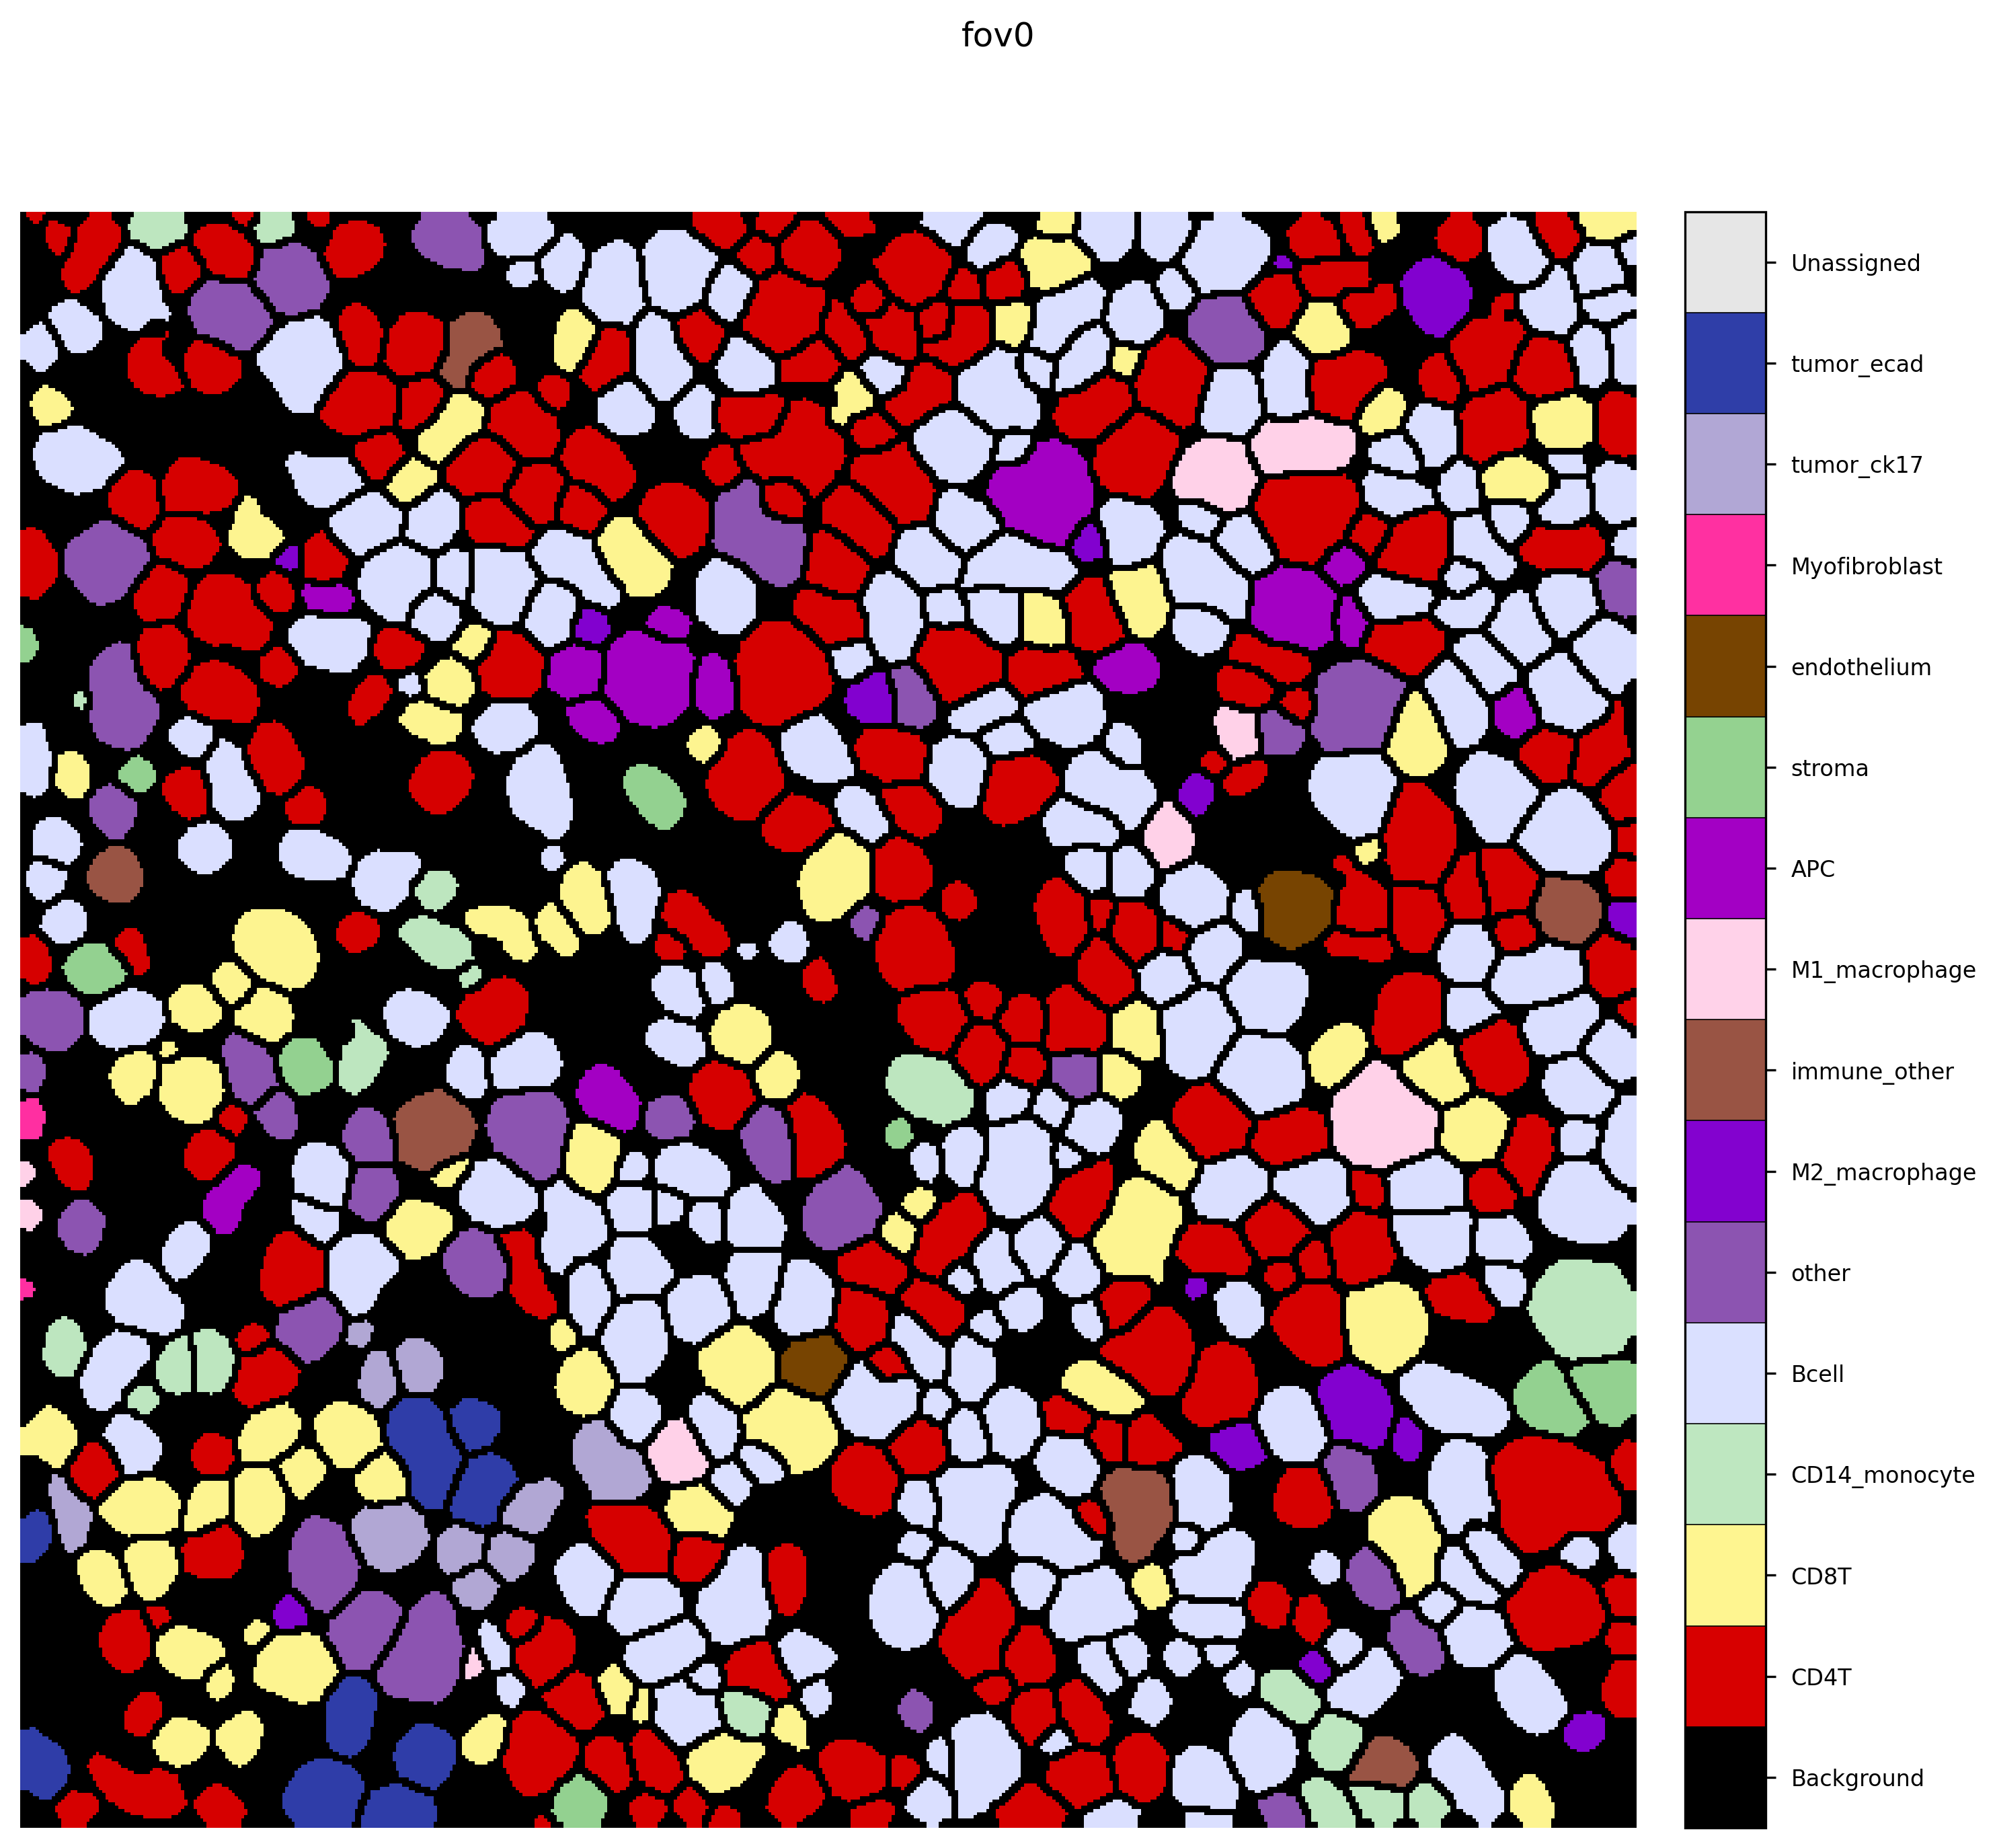

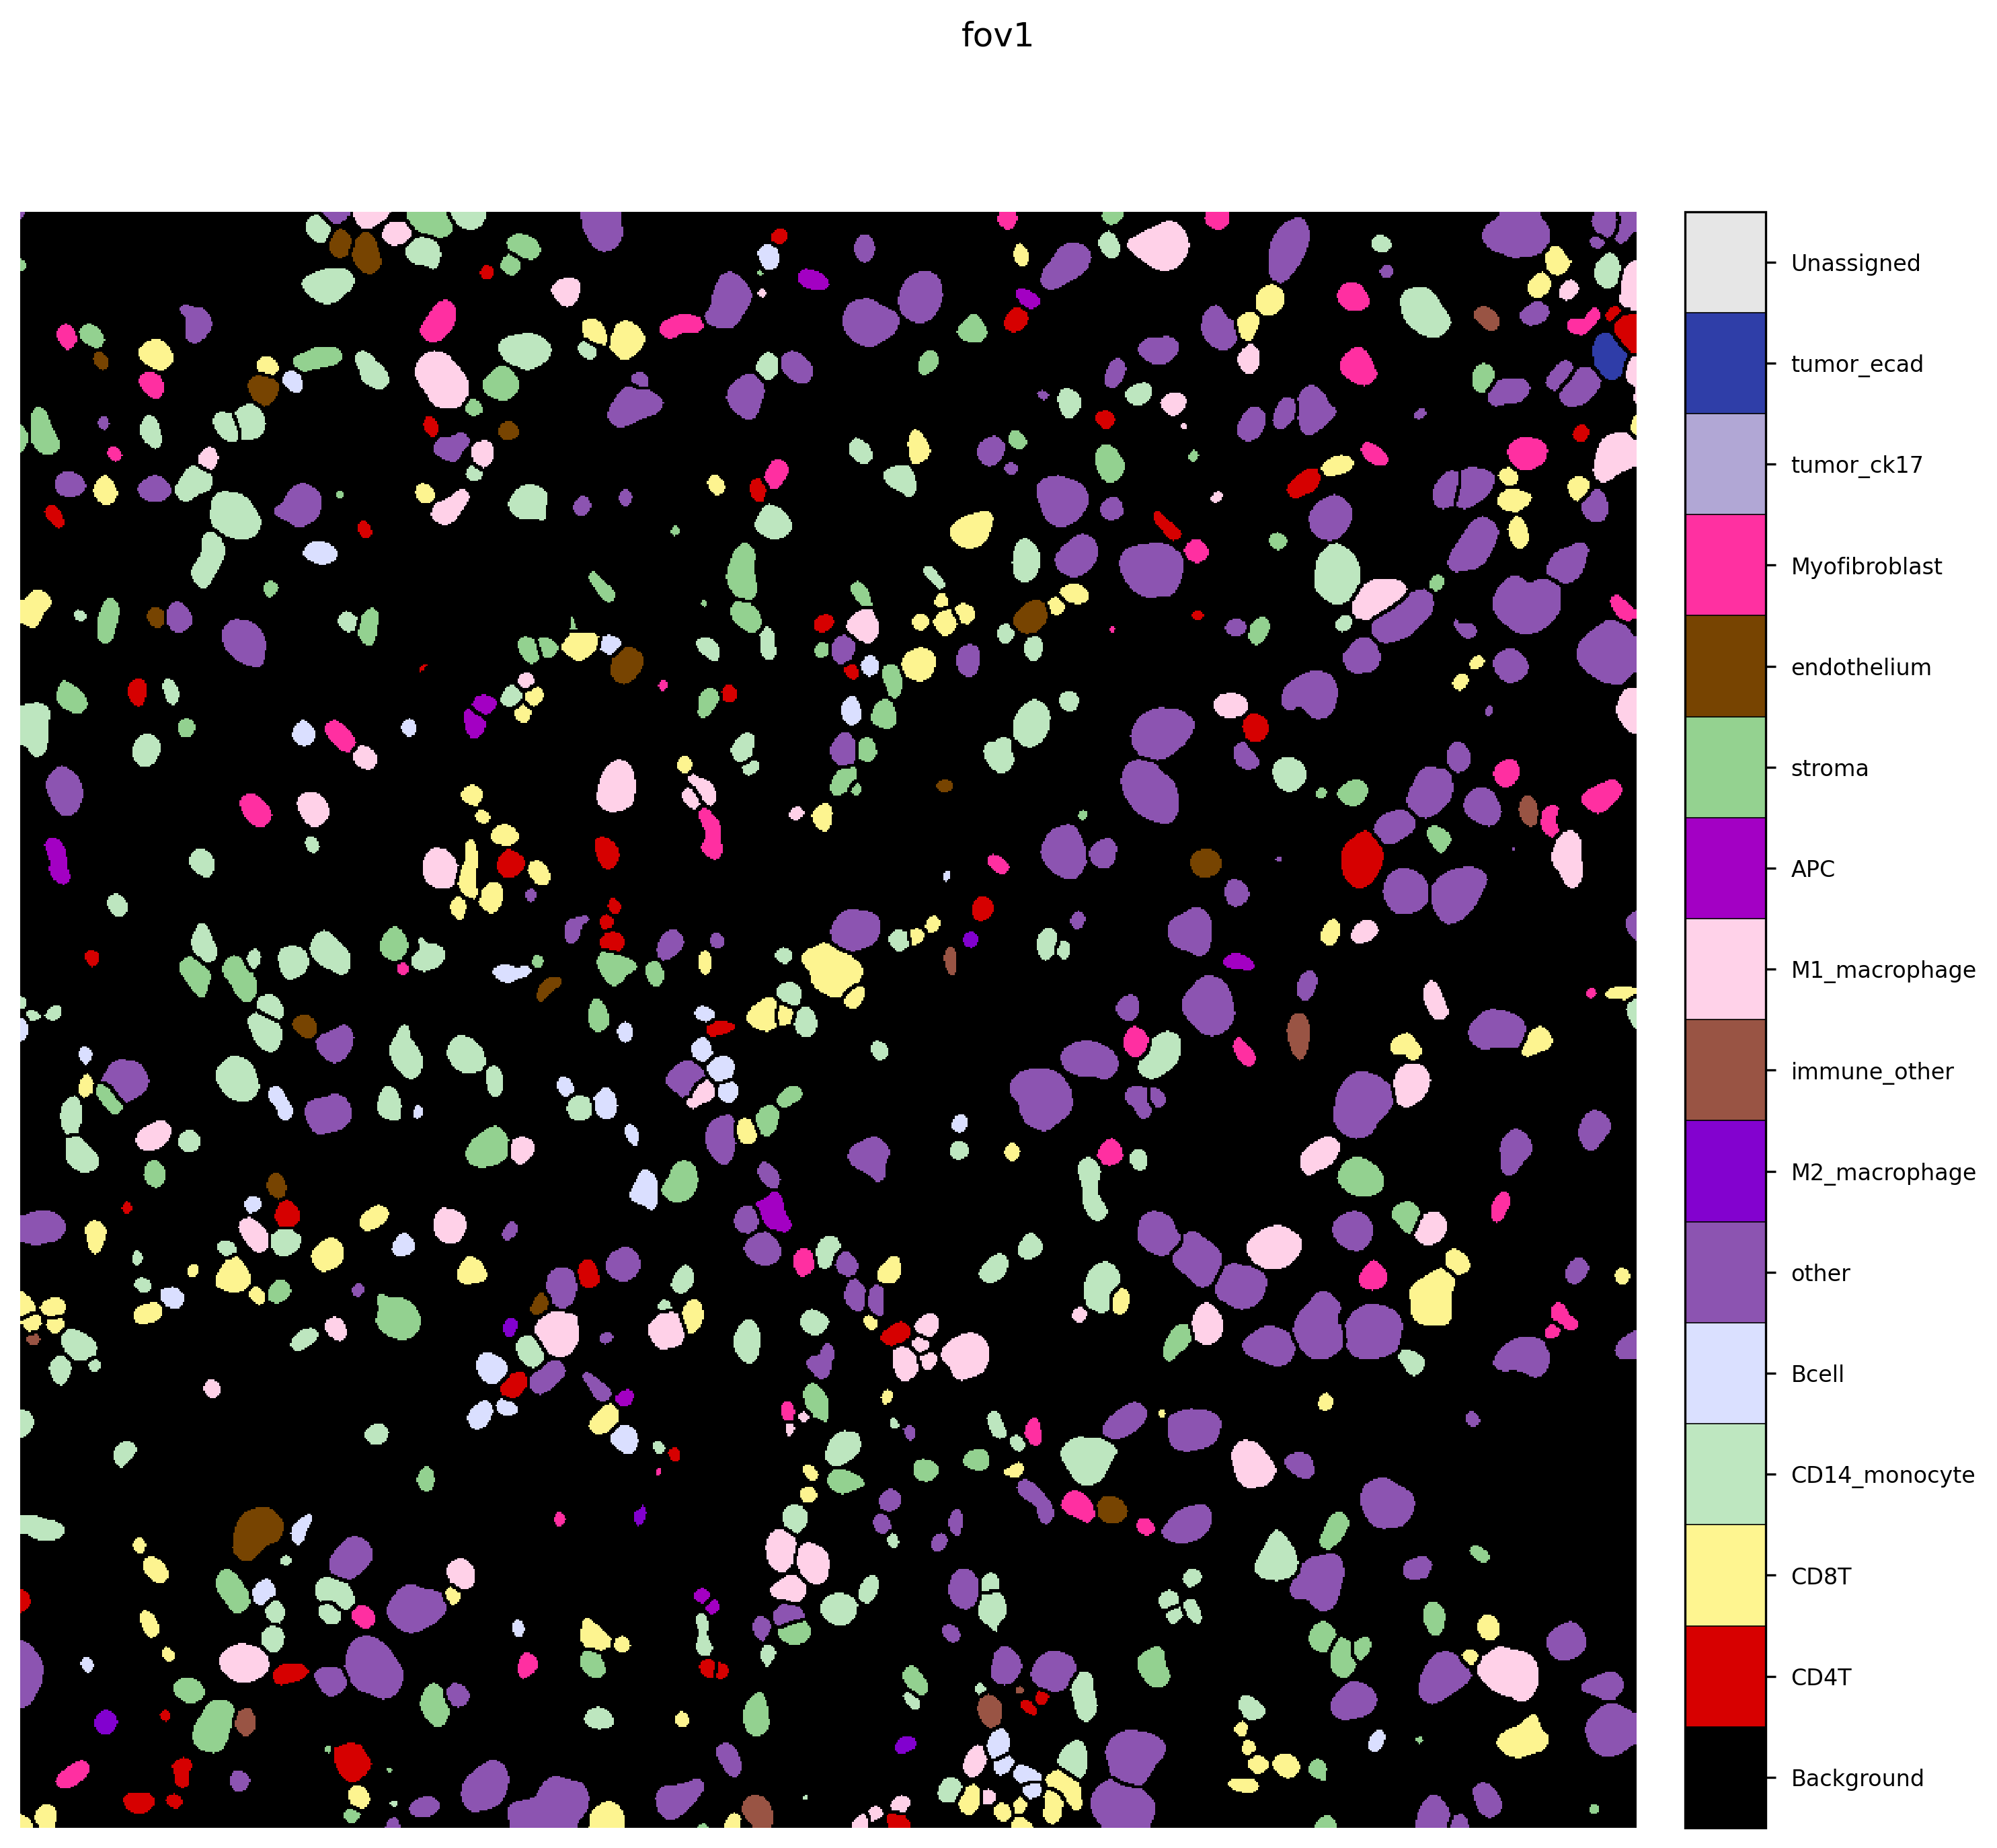

In [9]:
cohort_cluster_plot(
    fovs=fovs[0:2],
    seg_dir=seg_dir,
    save_dir="./cluster_plots",
    cell_data=fov_cell_cluster_df,
    erode=True,
    fov_col=settings.FOV_ID,
    label_col=settings.CELL_LABEL,
    cluster_col=settings.CELL_TYPE,
    seg_suffix="_whole_cell.tiff",
    cmap="cet_glasbey_bw_minc_20",
    display_fig=True,
    fig_file_type="png",
    figsize=(10, 10),
    dpi=300,
)

## 2. Continuous Variable Plots

This section of the notebook allows you to plot many images with a color map of your choice. You will need to set the following variables / files:



1. A directory containing segmentation masks labeled with integers [$0, 1, 2, 3, ...N$], where $0$ is the exclusive to the background.
2. A `.csv` consisting of a column of FOV / image names, a column of segmentation IDs for each image and a column of containing the statistic of interest. Here is an example of the format below:


| fov | segmentation_id | statistic |
|-----|-----------------|------------|
| fov0   | 1               | 0.17  |
| fov0   | 2               | 0.04  |
| ... | ...             | ...        |
| fovM   | N               | 0.87  |


### 1. Set the File Paths

- `base_dir`: The base directory of the cohort.
- `image_dir`: Sets the path to the directory containing the images.
- `seg_dir`: Sets the path to the directory containing the segmentation labels, these can be cells, fibers, or anything else which is "segmented" in a given FOV.
- `data_table_path`: Sets the path to a `.csv` file containing a column for 


In [10]:
base_dir = "../data/example_dataset/"
seg_dir = os.path.join(base_dir, "segmentation", "deepcell_output")

In [11]:
image_dir = os.path.join(base_dir, "image_data")
fovs = ns.natsorted(io_utils.list_folders(image_dir))

In [12]:
data_table_path = os.path.join(
    base_dir, "segmentation", "cell_table", "cell_table_size_normalized_cell_labels.csv"
)

In [13]:
data_table_df = pd.read_csv(data_table_path)

### 2. Set Plotting Parameters

- `fov_col`: The column name of the FOV / image names.
- `label_col`: The column name of the segmentation ID / labels.
- `stat_name`: The column name of the statistic of interest.
- `seg_suffix`: The suffix of the segmentation masks of interest.
- `cmap`: The colormap to use for the plot.
- `reverse`: Whether to reverse the colormap.
- `erode`: Whether to erode the segmentation labels. Recommended setting to `True` if your segmentation masks are very busy.
- `style`: The plotting style sheet to be used. View the available options [here](https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html).
- `display_fig`: Whether to display the figure. Recommended setting to `False` if you are generating many plots, as keeping many plots open will consume a lot of memory.
- `fig_file_type`: The file type to save the figure as. Options include `"png"`, `"pdf"`, `"svg"`, and any other type supported by `matplotlib`.
- `figsize`: The size of the figure, pass in a tuple of the form `(width, height)`.
- `dpi`: The resolution of the figure.


In [14]:
fov_col = settings.FOV_ID
label_col = settings.CELL_LABEL
stat_name = "convex_area"
seg_suffix = "_whole_cell.tiff"

In [15]:
import cmocean

cmap = "cmo.thermal"

In [16]:
# Run this cell to view the available plotting styles

# plt.style.available

Generating convex_area Plots:   0%|          | 0/2 [00:00<?, ?FOVs/s]

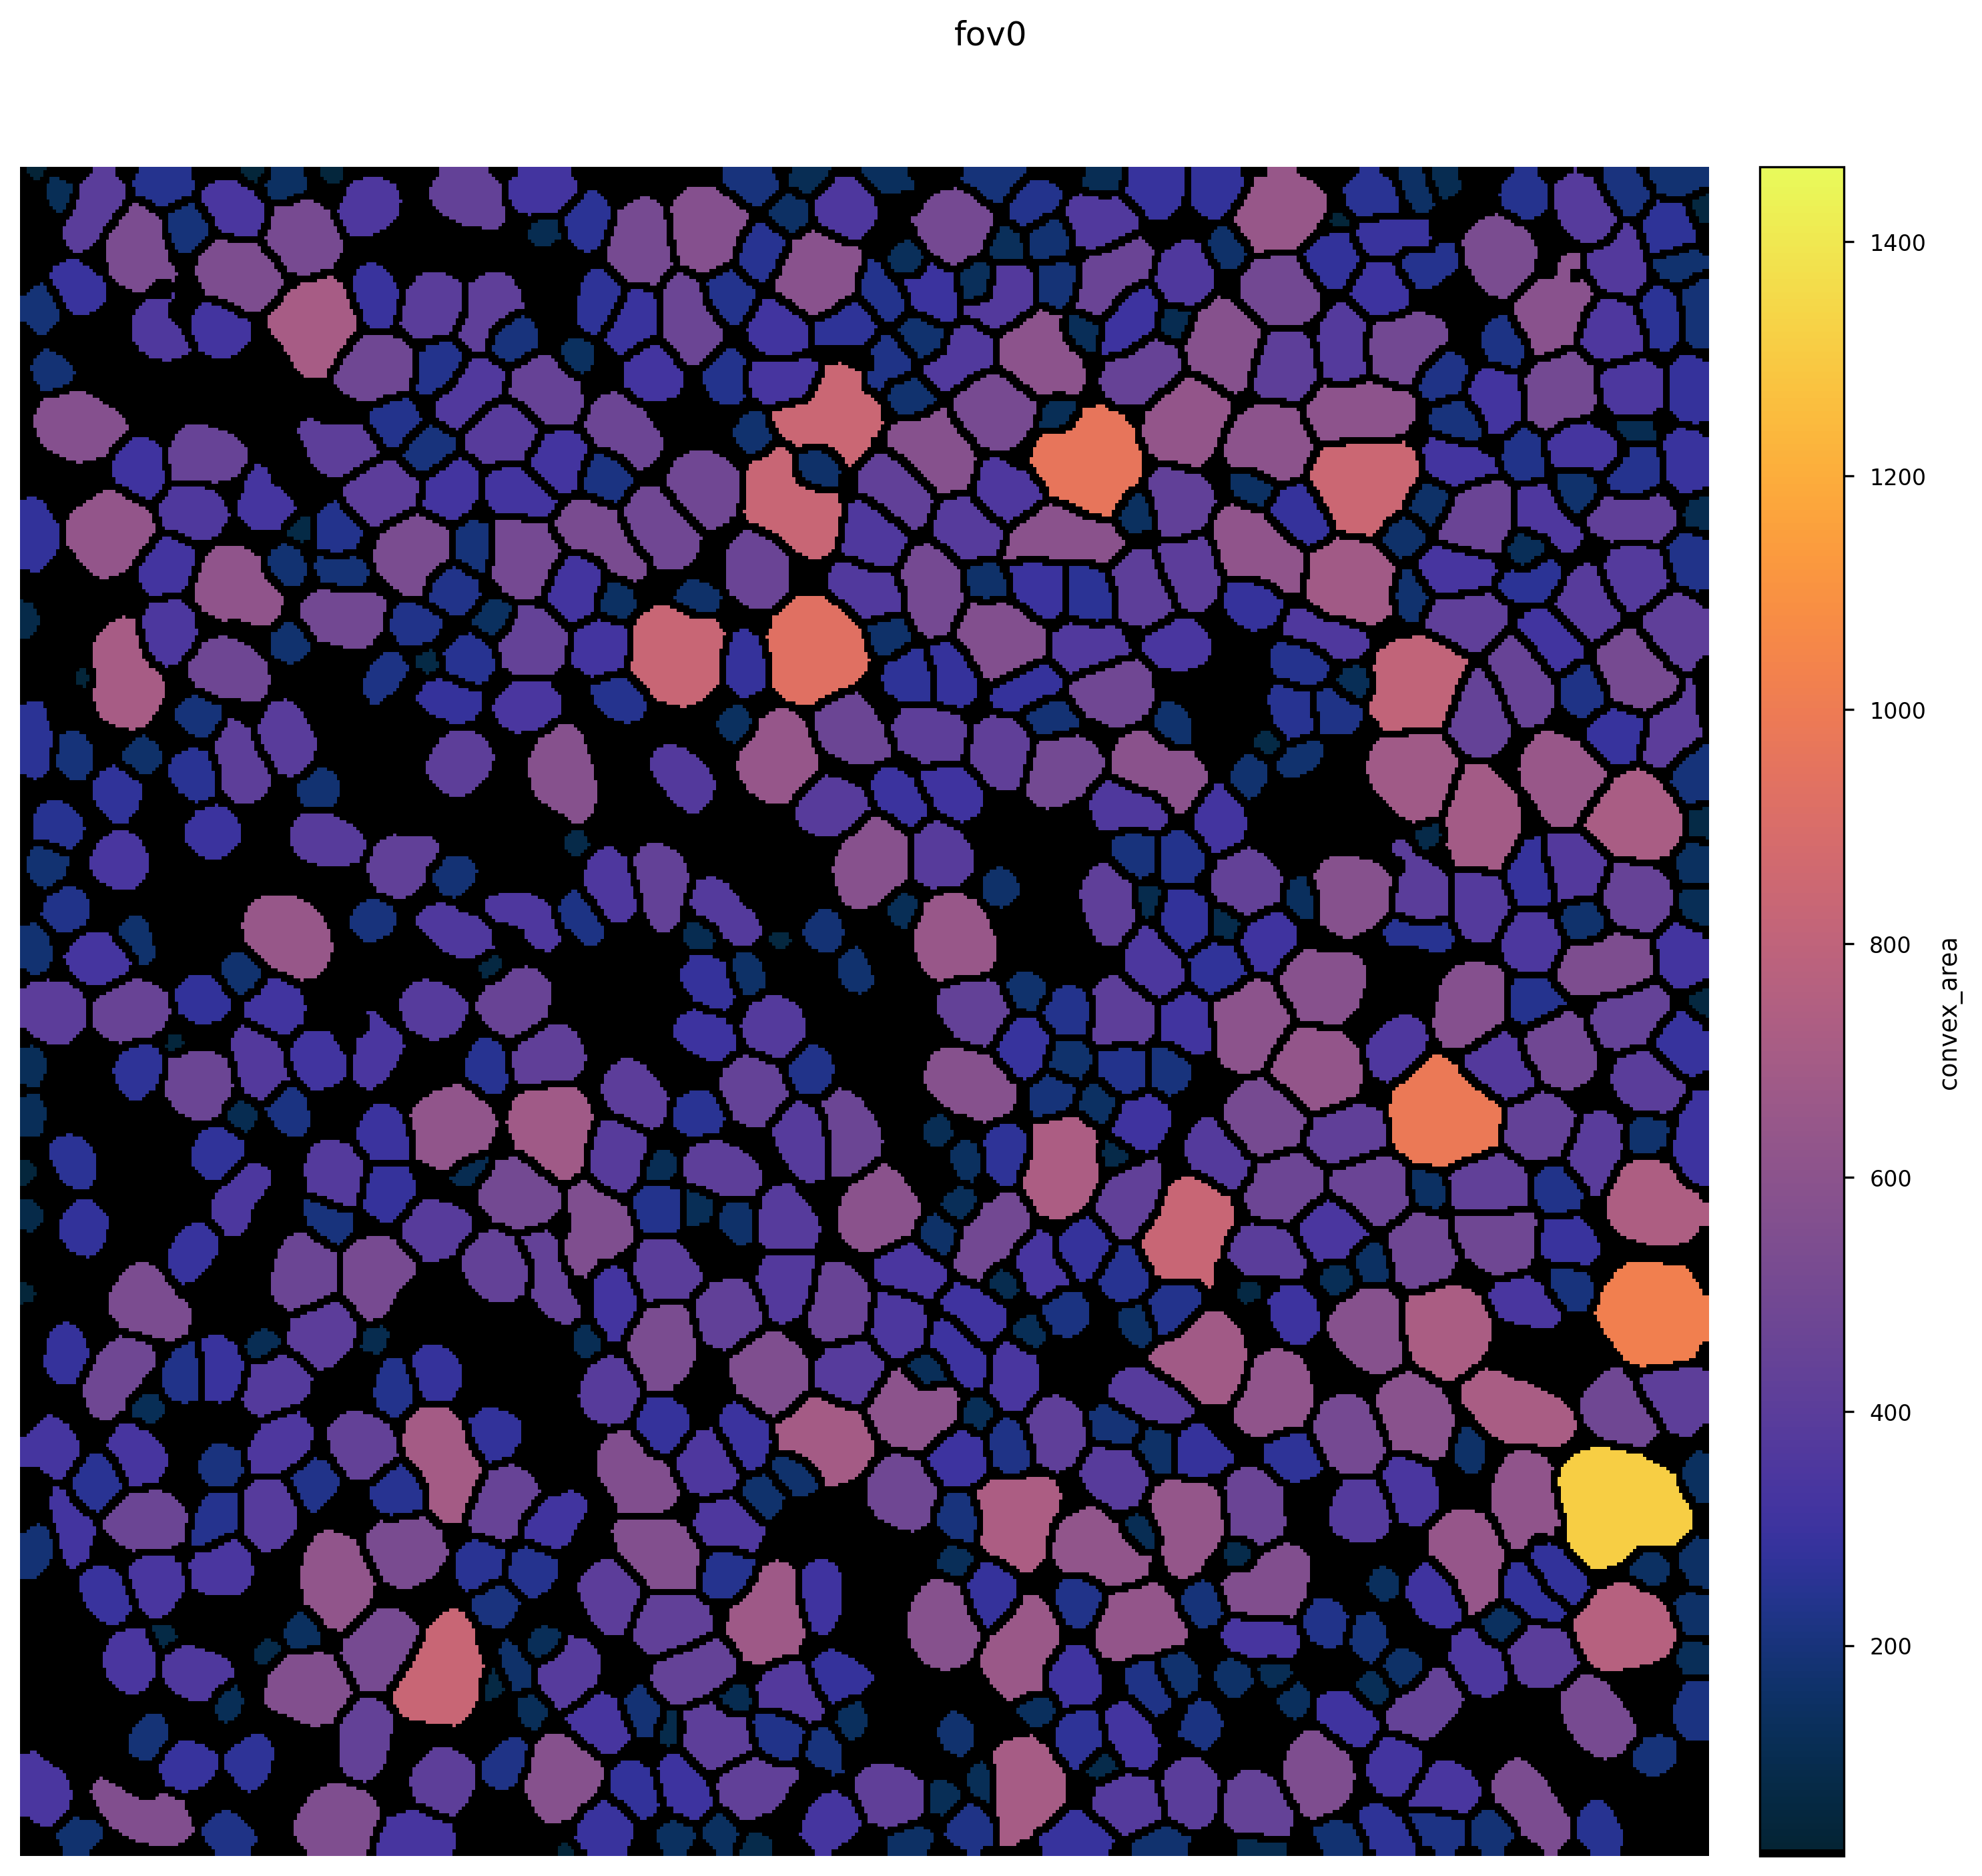

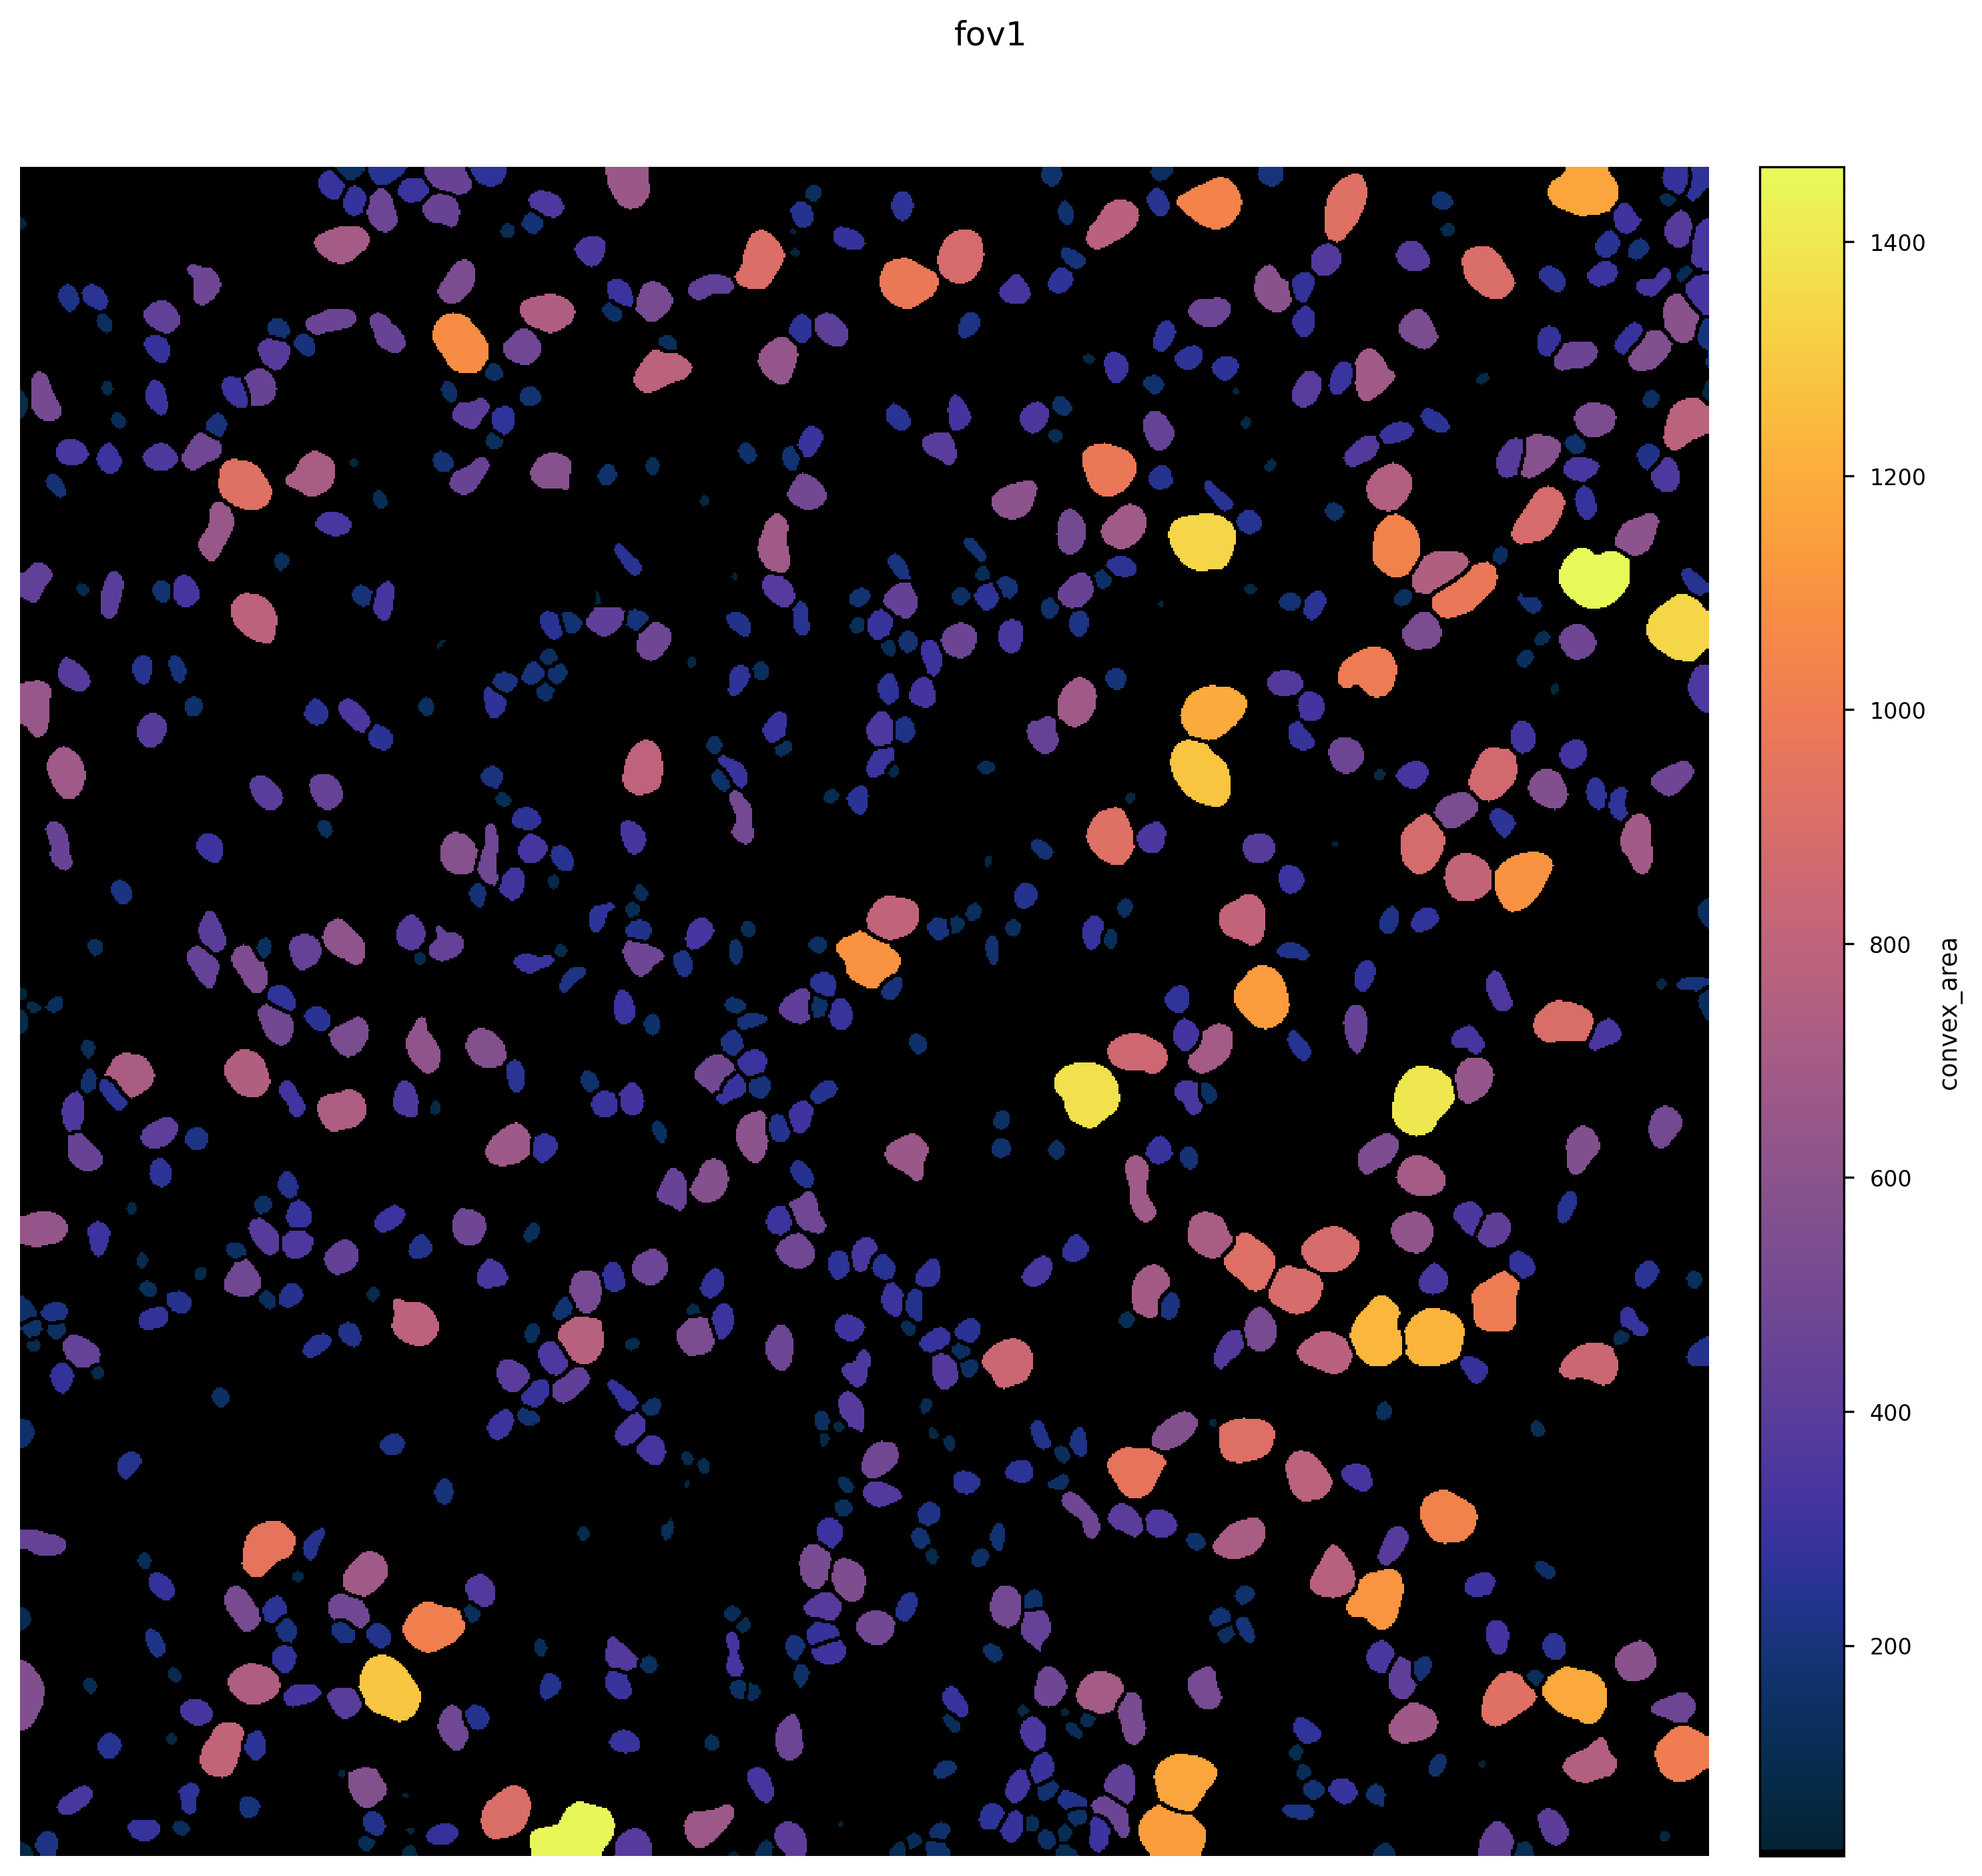

In [17]:
color_segmentation_by_stat(
    fovs=fovs[0:2],
    data_table=data_table_df,
    seg_dir=seg_dir,
    save_dir="./statistic_plots",
    fov_col=fov_col,
    label_col=label_col,
    stat_name=stat_name,
    cmap=cmap,
    reverse=False,
    seg_suffix=seg_suffix,
    erode=True,
    style="seaborn-v0_8-paper",
    display_fig=True,
    fig_file_type="png",
    figsize=(10, 10),
    dpi=300,
)